In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(linewidth=200) # Sets message printing width for easier readability

#-- Add utility directories to path to easily use utility .py files --#
import os.path
from os import path
import sys
sys.path.append("../utilityFunctions/")
sys.path.append("plottingUtils/")

# Set default fonts to Computer Modern (LaTeX)
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
#-- Boolean flags to change options --#
NGEN       = 3
CASE       = 4     # Must be 0, 1, 2, 3, 4   (see below for definitions)
DEBUG      = True
PLOTRANGE  = 'BP1' #! Rename variable, BENCHMARK
SMOOTH     = True  # Whether to smooth posterior and likelihood estimates using a Gaussian filter
if SMOOTH:
    SIGMA = 1
    ORDER = 0

In [3]:
#-- Option parameters, here for convenience --# #! Condense all of these in one place, better names
if PLOTRANGE == 'BP1':
    txtFilename         = '../Data/ulyssesScanResults/ULSNEST_Ngen%s_BP1.txt'%str(NGEN)
    plotTitle           = 'Benchmark Point 1 (BP1)'
elif PLOTRANGE == 'BP2':
    txtFilename         = '../Data/ulyssesScanResults/ULSNEST_Ngen%s_BP2.txt'%str(NGEN)
    plotTitle           = 'Benchmark Point 2 (BP2)'

In [4]:
#-- Scanning parameters --#
# NOTE: This notebook assumes 2d scan in fpi_pow and bsmall_pow, might do more general case later if necessary

# Parameters which were scanned over corresponding to columns 2:-1 in txtFilename (in order)
scanParamsNameList  = ['fpi_pow', 'bsmall_pow']  

# Definition of scan parameters
#   fpi_pow     = log_10(fpi/GeV) 
#   bsmall_pow  = log_10(bsmall) 
#   where mDM = bsmall*lamW = 4*np.pi*bsmall*fpi GeV$

# Load data from MultiNest scan into dictionary

The data produced by the multinest scan are the posterior and negative 2 log-likelihood values for a given parameter point. See here for more details on multinest output format: https://github.com/farhanferoz/MultiNest.

Note that the negative 2 log-likelihood has been defined as:

$\mathcal{l} = -2 \ln \mathcal{L} = \left( \frac{x(\theta) - x_0}{\Delta x}\right)^2$

where $x_0$ represents the experimentally measured value and $\Delta x$ represents the $1 \sigma$ error on the measurement. For our scenario we have (see arXiv: 1807.06209):

- $x(\theta) = \Omega h^2 (\theta) = \Omega h^2 ({\rm bsmall}, {\rm f_\pi})$ 
- $x_0 = (\Omega h^2)_{\rm PDG} = 0.1200$
- $\Delta x = \Delta(\Omega h^2) = 0.0012$

Thus we can get the likelihood via $ \mathcal{L} = e^{-0.5*l}$

(722, 4)
(722,)
(692, 4)
Negative 2 log-likelihood max, min:  442.12863888690214 6.657712803942876e-06
Posterior max, min, and sum:         0.0035615300459288825 9.841874788976885e-98 0.9333199947333253

Complete dictionary keys:        ['posterior', 'likelihood', 'neg2Log_likelihood', 'oh2', 'fpi_pow', 'bsmall_pow']
Scan parameter dictionary keys:  ['fpi_pow', 'bsmall_pow']

Original data columns:
           posterior           likelihood              fpi_pow           bsmall_pow
9.841874788976885e-98 9.839792042724354e-97    4.715875180137562  -2.1004693546271422
2.1444979640628025e-97 2.1583855226100414e-96    4.812797614038777   -2.911518024163199
7.245329976321667e-97 7.341027433708552e-96    4.558957217827484  -2.8295306724285876
7.973309680715826e-97 8.132659815762124e-96    4.588274227093256    -2.69360163055587
4.4822869355718995e-95 4.6024483700424635e-94    4.568068070614942   -2.798715059149611

Added data columns:
  neg2Log_likelihood                  oh2
  442.12863888690

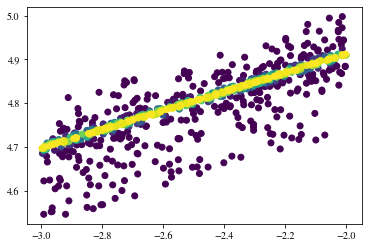

In [5]:
#--------------------#
#-- Open data file --#
#--------------------#
df = np.loadtxt(txtFilename, dtype=np.double)
print(df.shape)

#--------------------------------------------------------#
#-- Set posterior and negative 2 log-likelihood values --#
#--------------------------------------------------------#

#-- See arXiv: 1807.06209 for experimental values --#
oh2_PDG   = 0.1200
delta_oh2 = 0.0012


#! Remove problematic points (fix at source later)
import numpy.ma as ma
mask  = ~ma.masked_where(df[:,1] <= 1e-30, df[:,1]).mask
print(mask.shape)

df_new = np.zeros(shape=(df[:,1][mask].shape[0], df.shape[1]))
print(df_new.shape)
df_new[:,0] = df[:,0][mask]
df_new[:,1] = df[:,1][mask]
df_new[:,2] = df[:,2][mask]
df_new[:,3] = df[:,3][mask]

df = df_new
#!---------------------------------------------

#-- Create dictionary to store everything --#
dfDict = {}
dfDict["posterior"]          = df[:,0]
neg2Log_likelihood           = df[:,1]

dfDict["likelihood"]         = np.exp(-0.5*neg2Log_likelihood)
dfDict["neg2Log_likelihood"] = neg2Log_likelihood
dfDict["oh2"]                = np.sqrt(dfDict["neg2Log_likelihood"]*delta_oh2) + oh2_PDG
if DEBUG:
    print("Negative 2 log-likelihood max, min: ", dfDict["neg2Log_likelihood"].max(), dfDict["neg2Log_likelihood"].min())
    print("Posterior max, min, and sum:        ", dfDict["posterior"].max(),          dfDict["posterior"].min(),         dfDict["posterior"].sum())
    print("")
    

#-- Set parameter values into a dictionary corresponding to scanParamsNameList and an overall dfDict--#

# Note that order in scanParamsNameList must be the same as in txtFilename 
# Note also that scans are done in log scale e.g. we scan in fpi_pow = log_10(fpi/GeV)

scanParamsDict = {}
for i in range(2, df.shape[1]):
    scanParamsDict[scanParamsNameList[i-2]] = df[:,i]
    dfDict[scanParamsNameList[i-2]]         = df[:,i]

if DEBUG:  
    print("Complete dictionary keys:       ",list(dfDict.keys()))
    print("Scan parameter dictionary keys: ",list(scanParamsDict.keys()))
    print("")
    
    from printUtils import prettyPrintColumns
    
    print("Original data columns:")
    origKeyList = ['posterior', 'likelihood']
    for i in range(len(scanParamsNameList)):
        origKeyList.append(scanParamsNameList[i])
 
    prettyPrintColumns({key: dfDict[key] for key in origKeyList} )
    print("")
    
    print("Added data columns:")
    prettyPrintColumns({key: dfDict[key] for key in dfDict.keys() if key not in origKeyList} )
    print("")
    
    print("Raw scatterplot of datapoints:")
    plt.scatter(dfDict['bsmall_pow'], dfDict['fpi_pow'], c=dfDict["likelihood"], cmap="viridis")
    plt.show()

In [6]:
# #Remove really small points < 10^{-100}
# import numpy.ma as ma
# mask        = ~ma.masked_where(dfDict["neg2Log_likelihood"] <= 1e-30, dfDict["neg2Log_likelihood"]).mask
# bsmall_pow  = dfDict['bsmall_pow'][mask]
# fpi_pow     = dfDict['fpi_pow'][mask]
# likelihood  = dfDict["likelihood"][mask]

# plt.scatter(bsmall_pow, fpi_pow, c=likelihood, cmap="viridis")
# plt.show()

In [7]:
# from omegaH2 import omegaH2
# fpi    = 10.**(0.588172368298773840E+01)
# bsmall = 10.**(-0.236574651893888444E+01) # do 2.4 point
# print(fpi, bsmall)
# kwargs    = {"Ngen":NGEN, "gs":0.8, "kappa":1.0, "eQ":0.5, "sQsq":0.3} #BP1
# kwargs["fpi"]    = fpi
# kwargs["bsmall"] = bsmall
# print(omegaH2(**kwargs))

# Convert Parameters into those we want to plot

Here we transform $\theta_1,...,\theta_n \rightarrow \theta'_1,...,\theta'_n$. Note that for the transformations considered, $x(\theta) = x(\theta')$ therefore $\mathcal{l}$ and thus $\mathcal{L}$ should stay the same. 

Technically the posterior would need to be transformed by the Jacobian since it is normalized over the space of parameters. 

However, since in this case it's normalized over this finite set of points, no transformation is necessary however we calculate and store the Jacobian for good measure. The Jacobian for a transformation from $\theta_1,...,\theta_n \rightarrow \theta'_1,...,\theta'_n$ is defined as 

$J = |\frac{\partial(\theta'_1,...,\theta'_n)}{\partial(\theta_1,...,\theta_n)}|$ then $ d \theta'_1...d \theta'_n = J d \theta_1...d \theta_n$ 

Therefore the posterior $p(\theta | D)$ where $D$ is the data and $\theta$ are the parameters transforms to $p(\theta' | D) = J p(\theta | D)$. 

https://mathworld.wolfram.com/Jacobian.html

There are 5 possible cases assuming the scan parameters bsmall_pow and fpi_pow enumerated below.

##### Case 0: If plotting in log_10 and original scan parameters still
- $\theta  = \{$ bsmall_pow, fpi_pow$\}  \rightarrow   \theta' = \{$ bsmall_pow, fpi_pow$\}$

Equivalent to CONVERTPARAMS=False

##### Case 1: If plotting in log_10 still but different scan parameters
- $\theta = \{$ bsmall_pow, fpi_pow$\} \rightarrow \theta' = \{$ mD_pow, fpi_pow $\}$ where mD_pow $= {\rm log}_{10}(4 \pi) +$ fpi_pow $+$ bsmall_pow

##### Case 2: If NOT plotting in log_10
- $\theta = \{$ bsmall_pow, fpi_pow$\} \rightarrow \theta'  = \{$ mD (GeV), fpi (GeV)$\}$ where mD $= 4 \pi 10.^{{\rm fpi \_ pow}} 10.^{{\rm bsmall \_ pow}}$ and fpi $= 10.^{{\rm fpi \_ pow}}$

##### Case 3: If NOT plotting in log_10 and want fpi in TeV
- $\theta = \{$ bsmall_pow, fpi_pow$\} \rightarrow \theta'  = \{$ mD (GeV), fpi (TeV)$\}$ where mD $= 4 \pi 10.^{{\rm fpi \_ pow}} 10.^{{\rm bsmall \_ pow}}$ and fpi $= 10.^{{\rm fpi \_ pow}-3}$

##### Case 4: If NOT plotting in log_10 and want both fpi and mD in TeV
- $\theta = \{$ bsmall_pow, fpi_pow$\} \rightarrow \theta'  = \{$ mD (TeV), fpi (TeV)$\}$ where mD $= 4 \pi 10.^{{\rm fpi \_ pow}} 10.^{{\rm bsmall \_ pow}}$ and fpi $= 10.^{{\rm fpi \_ pow}-3}$

In [8]:
print("Using CASE = ",CASE)

Using CASE =  4


In [9]:
#-- Define desired x and y axis keys depending on CASE --#
# The key of the desired x-axis and y-axis values
if CASE == 0:
    xkey = 'bsmall_pow' 
    ykey = 'fpi_pow'
    xAxisTitle = r'${\rm log}_{10}(b_{\rm small})$'
    yAxisTitle = r'${\rm log}_{10}(f/{\rm GeV})$'
elif CASE == 1:
    xkey = 'mD_pow' 
    ykey = 'fpi_pow'
    xAxisTitle = r'${\rm log}_{10}(m_{\rm DM}/{\rm GeV})$'
    yAxisTitle = r'${\rm log}_{10}(f/{\rm GeV})$'
elif CASE == 2:
    xkey = 'mD_GeV' 
    ykey = 'fpi_GeV'
    xAxisTitle = r'$m_{\rm DM}$ [GeV]'
    yAxisTitle = r'$f$ [GeV]'
elif CASE == 3:
    xkey = 'mD_GeV' 
    ykey = 'fpi_TeV'
    xAxisTitle = r'$m_{\rm DM}$ [GeV]'
    yAxisTitle = r'$f$ [TeV]'
elif CASE == 4:
    xkey = 'mD_TeV' 
    ykey = 'fpi_TeV'
    xAxisTitle = r'$m_{\rm DM}$ [TeV]'
    yAxisTitle = r'$f$ [TeV]'

New complete data dictionary keys:  ['posterior', 'likelihood', 'jacobian', 'fpi_TeV', 'mD_TeV']

Old data:
Likelihood max, min:          0.9999966711491387 9.839792042724354e-97
Posterior max, min, and sum:  0.0035615300459288825 9.841874788976885e-98 0.9333199947333253

           posterior           likelihood              fpi_pow           bsmall_pow
9.841874788976885e-98 9.839792042724354e-97    4.715875180137562  -2.1004693546271422
2.1444979640628025e-97 2.1583855226100414e-96    4.812797614038777   -2.911518024163199
7.245329976321667e-97 7.341027433708552e-96    4.558957217827484  -2.8295306724285876
7.973309680715826e-97 8.132659815762124e-96    4.588274227093256    -2.69360163055587
4.4822869355718995e-95 4.6024483700424635e-94    4.568068070614942   -2.798715059149611

New data:
Likelihood max, min:          0.9999966711491387 9.839792042724354e-97
Posterior max, min, and sum:  14.593814320776392 7.396803534217972e-95 1163.7544187994245

           posterior           likel

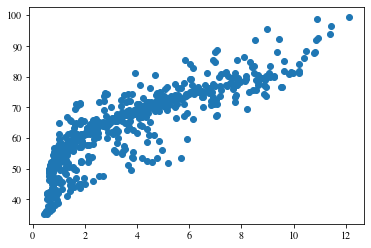

In [10]:
from jacobianConvert import JacobianConvert2D
dfDict_new = JacobianConvert2D(dfDict, CASE=CASE)

if DEBUG: 
    print("New complete data dictionary keys: ",list(dfDict_new.keys()))
    print("")
    
    print("Old data:")
    print("Likelihood max, min:         ", dfDict["likelihood"].max(), dfDict["likelihood"].min())
    print("Posterior max, min, and sum: ", dfDict["posterior"].max(),  dfDict["posterior"].min(), dfDict["posterior"].sum())
    print("")
    from printUtils import prettyPrintColumns
    
    # Define truncated dfDict with keys ['posterior', 'likelihood', 'fpi_pow', 'bsmall_pow'] #! make more general later
    dfDict_trunc = {key: dfDict[key] for key in ['posterior', 'likelihood', 'fpi_pow', 'bsmall_pow']}
    
    prettyPrintColumns(dfDict_trunc)
    print("")
    
    print("New data:")
    print("Likelihood max, min:         ", dfDict_new["likelihood"].max(), dfDict_new["likelihood"].min())
    print("Posterior max, min, and sum: ", dfDict_new["posterior"].max(),  dfDict_new["posterior"].min(), dfDict_new["posterior"].sum())
    print("")
    from printUtils import prettyPrintColumns
    
    # Define truncated dfDict with keys ['posterior', 'likelihood', 'fpi_pow', 'bsmall_pow'] #! make more general later
    dfDict_new_trunc = {key: dfDict_new[key] for key in ['posterior', 'likelihood', xkey, ykey]}
    
    prettyPrintColumns(dfDict_new_trunc)
    print("")
    
    print("Scatterplot of converted datapoints:")
    plt.scatter(dfDict_new[xkey], dfDict_new[ykey])
    plt.show()

# Define grid for analysis and plotting

In [11]:
print("Using xkey, ykey: ",xkey, ykey)

Using xkey, ykey:  mD_TeV fpi_TeV


In [12]:
#-- Define plotting range --#
if(PLOTRANGE == 'BP1'):
    xmin = 0.5  #TeV
    xmax = 10.5 #TeV
    ymin = 40   #TeV
    ymax = 94   #TeV
elif(PLOTRANGE == 'BP2'):
    xmin = 0.5  #TeV
    xmax = 10.5 #TeV
    ymin = 40   #TeV
    ymax = 94   #TeV
    
axisRange = [xmin, xmax, ymin, ymax]

#-- Define number of meshgrid points to use in plot --#
# This is the number of times the kernel functions will be sampled
# Ex. 100j will sample kernel on a 100x100 grid over the specified xy range
# Note this is complex (*j) because ...
gMesh = 20j

if DEBUG:
    print("axisRange:")
    print("xmin, xmax, ymin, ymax: ",xmin, xmax, ymin, ymax)
    print("")
    print("dataRange:")
    print("xmin, xmax, ymin, ymax: ",dfDict_new[xkey].min(), dfDict_new[xkey].max(), dfDict_new[ykey].min(), dfDict_new[ykey].max())

axisRange:
xmin, xmax, ymin, ymax:  0.5 10.5 40 94

dataRange:
xmin, xmax, ymin, ymax:  0.4505329274302682 12.116209404158418 35.1691418048953 99.50902207462025


# Estimate posterior and likelihood on grid of points for analysis and plotting

The data is sampled irregularly, in order to plot we need to create a uniform mesh grid of the posterior and likelihood functions. 

Copying and modifying slightly from superplot (https://github.com/michaelhb/superplot) we do this in the following ways.

#### Posterior PDF
Since the posterior is a normalized function (dfDict_new["posterior"].sum() ~= 1) we can easily estimate its PDF with a histogram. Note that you could also do this with a KDE strategy. However, as noted in the superplot documentation (https://arxiv.org/pdf/1603.00555.pdf), this will cause oversmoothing and underestimates of the PDF at artificial boundaries. So instead we go with the histogram method.

The strategy is to create a weighted histogram with these irregularly sampled values. The bin centers and the bin values thus become the regular grid of points which we will use for analysis and plotting.

#### Profile likelihood
For the likelihood, things are a bit trickier. We actually have to estimate the 2D "profile-likelihood". First we use the definition that $-2 {\rm ln}(\mathcal{L}/\mathcal{L}_{\rm max}) = \chi^2$. Which can be rewritten as $\chi^2 = [-2 {\rm ln}(\mathcal{L})] - [-2 {\rm ln}(\mathcal{L}_{\rm max})]$

Note that in a frequentist perspective $\mathcal{L}_{\rm max} = 1$ (and thus $-2 {\rm ln}(\mathcal{L}_{\rm max}) = 0$), in a Bayesian perspective we should use the numerically found maximum (minimum) instead.

The strategy is to first create a histogram solely to define the edges of the bins. We then find the minimum $\chi^2$ value that falls in each given bin. If a bin is empty its value is set to "inf". This defines the grid of the profile-$\chi^2$. From this we can then get the gridded profile-likelihood = np.exp(-0.5*profile-$\chi^2$).

In [13]:
#-- Estimate posterior and profile-likelihood on grid --#
from statUtils import getFuncOnGrid
posteriorDict   = getFuncOnGrid(dfDict_new, xkey, ykey, 'posterior',  axisRange, gMesh)
likelihoodDict  = getFuncOnGrid(dfDict_new, xkey, ykey, 'likelihood', axisRange, gMesh)

In [14]:
#-- If smoothing data is specified, smooth data before analysis and plotting --#
if SMOOTH:
    from statUtils import smoothData
    posteriorDict["Z"]  = smoothData(posteriorDict["Z"], SIGMA, ORDER, normType='sum')
    likelihoodDict["Z"] = smoothData(likelihoodDict["Z"], SIGMA, ORDER, normType='max')

# Define 1 and 2 $\sigma$ valid regions for posterior and likelihood

#### Posterior valid region

Calculate the critical probability alpha such that $\int_{p(x,y) \geq p_{crit}} p(x,y) dx dy = 1 - \alpha$.

Where $\alpha = 0.32 \rightarrow 1 \sigma$ and $\alpha = 0.05 \rightarrow 2 \sigma$.

In [15]:
from statUtils import findCriticalDensityVals
posteriorDict["critDensity"]  = findCriticalDensityVals(posteriorDict["Z"]) 

if DEBUG:
    print("2 \sigma critical value, 1 \sigma critical value")
    print(posteriorDict["critDensity"])

2 \sigma critical value, 1 \sigma critical value
[0.0021815545763101424, 0.009212377548997197]


#### Likelihood valid region
For a detailed discussion on critical levels for the profile likelihood see Appendix A.2 in the superplot documentation (https://arxiv.org/pdf/1603.00555.pdf) and "Statistical Methods in Experimental Physics" by Frederick James. Below is a summary.

Using the definition $\chi^2 = -2 {\rm ln}(\mathcal{L}/\mathcal{L}_{\rm max}) =: -2 {\rm ln}(\mathcal{l})$, we want to know what levels correspond to $1 \sigma$ and $2 \sigma$ agreement with experiment.

We are in agreement with experiment if $\chi^2 \leq F^{-1}_{\chi^2}(1-\alpha, {\rm dof}=2)$. 

For $1 \sigma$:
- $\alpha = 0.32$ and $\chi^2 \lesssim 2.27$ which implies $\mathcal{l} \gtrsim 0.32$
For $2 \sigma$:
- $\alpha = 0.05$ and $\chi^2 \lesssim 5.99$ which implies $\mathcal{l} \gtrsim 0.05$ 

In fact, it's generally true that $\mathcal{l} \gtrsim \alpha$ is the value to use, so there's no need for an explicit calculation. However, if you were to do one it would go like:

In [16]:
# Demonstration of general \alpha level calculation
#
# from scipy.stats import chi2
#
# for alpha in [0.32, 0.05]:
#   critical_chi_sq = chi2.ppf(1. - alpha, 2) # Inverse cdf, level alpha, dof = 2
#   critical_prof_like = np.exp(- 0.5 * critical_chi_sq)
#   print(critical_chi_sq, critical_prof_like)

In [17]:
likelihoodDict["critDensity"] = np.array([0.05, 0.32])

if DEBUG:
    print("2 \sigma critical value, 1 \sigma critical value")
    print(likelihoodDict["critDensity"])

2 \sigma critical value, 1 \sigma critical value
[0.05 0.32]


# Plot posterior and likelihood

In [18]:
from plotUtils import plotZcmap

We plot the posterior and likelihood. Once we're happy with the layout of these curves we can calculate aeff in this range.

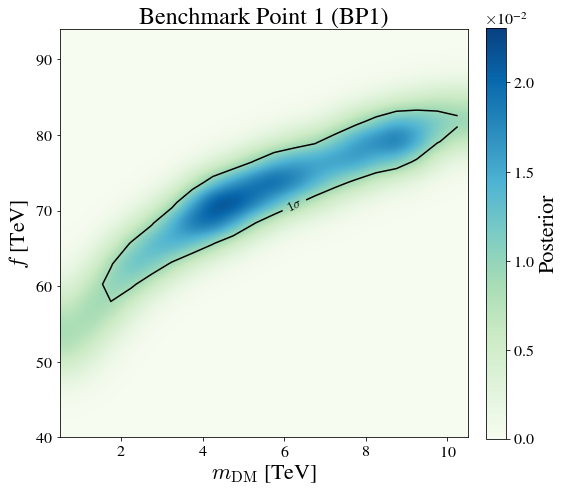

In [19]:
#-- Set stylistic elements of plot --#
posteriorPlotArgs = {  'plotTitle':  plotTitle,
              'zAxisTitle': r'Posterior',
              'xAxisTitle': xAxisTitle,
              'yAxisTitle': yAxisTitle,
              'interpType': 'quadric',
              'cmap':       'GnBu',
              'axisRange':  axisRange}

if PLOTRANGE == 'BP1':
    posteriorPlotArgs['plotName'] = 'paperPlots/BP1_Ngen%s_Posterior.pdf'%str(NGEN)
elif PLOTRANGE == 'BP2':
    posteriorPlotArgs['plotName'] = 'paperPlots/BP2_Ngen%s_Posterior.pdf'%str(NGEN)

#-- Set contour elements of plot --#
posteriorContourDict = {}
posteriorContourDict['sigContour'] = {}
XX, YY = np.meshgrid(posteriorDict["X"], posteriorDict["Y"])
posteriorContourDict['sigContour']['X_surface']    = XX
posteriorContourDict['sigContour']['Y_surface']    = YY
posteriorContourDict['sigContour']['Z_surface']    = posteriorDict["Z"]
posteriorContourDict['sigContour']['Z_constraint'] = np.full(posteriorDict["Z"].shape, posteriorDict["critDensity"][1])
posteriorContourDict['sigContour']['color']        = 'black'
posteriorContourDict['sigContour']['linestyle']    = '-'
posteriorContourDict['sigContour']['label']        = r'$1 \sigma$' 
posteriorContourDict['sigContour']['fontsize']     = 13

plotZcmap(posteriorPlotArgs, XX, YY, posteriorDict["Z"], contourDict=posteriorContourDict)

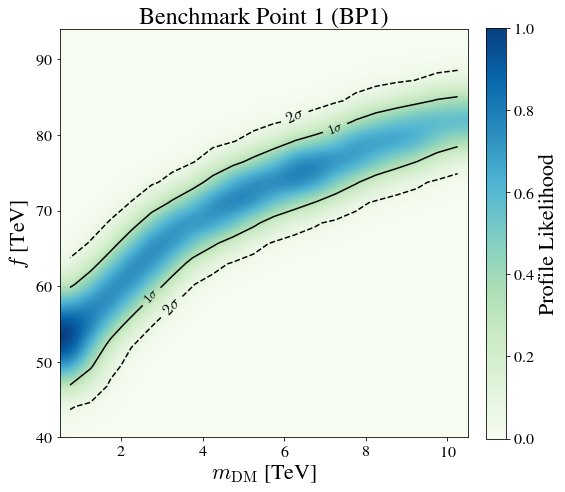

In [20]:
#-- Set stylistic elements of plot --#
likelihoodPlotArgs = {  'plotTitle':  plotTitle,
              'zAxisTitle': r'Profile Likelihood',
              'xAxisTitle': xAxisTitle,
              'yAxisTitle': yAxisTitle,
              'interpType': 'quadric',
              'cmap':       'GnBu',
              'axisRange':  axisRange}

if PLOTRANGE == 'BP1':
    likelihoodPlotArgs['plotName'] = 'paperPlots/BP1_Ngen%s_ProfileLikelihood.pdf'%str(NGEN)
elif PLOTRANGE == 'BP2':
    likelihoodPlotArgs['plotName'] = 'paperPlots/BP2_Ngen%s_ProfileLikelihood.pdf'%str(NGEN)

#-- Set contour elements of plot --#
likelihoodContourDict = {}
likelihoodContourDict['sigContour'] = {}
XX, YY = np.meshgrid(likelihoodDict["X"], likelihoodDict["Y"])
likelihoodContourDict['sigContour']['X_surface']    = XX
likelihoodContourDict['sigContour']['Y_surface']    = YY
likelihoodContourDict['sigContour']['Z_surface']    = likelihoodDict["Z"]
likelihoodContourDict['sigContour']['Z_constraint'] = np.full(likelihoodDict["Z"].shape, likelihoodDict["critDensity"][1])
likelihoodContourDict['sigContour']['color']        = 'black'
likelihoodContourDict['sigContour']['linestyle']    = '-'
likelihoodContourDict['sigContour']['label']        = r'$1 \sigma$' 
likelihoodContourDict['sigContour']['fontsize']     = 13

# Set profile likelihood significance plot
likelihoodContourDict['2sigContour'] = {}
likelihoodContourDict['2sigContour']['X_surface']    = likelihoodDict["X"]
likelihoodContourDict['2sigContour']['Y_surface']    = likelihoodDict["Y"]
likelihoodContourDict['2sigContour']['Z_surface']    = likelihoodDict["Z"]
likelihoodContourDict['2sigContour']['Z_constraint'] = np.full(likelihoodDict["Z"].shape, likelihoodDict["critDensity"][0])
likelihoodContourDict['2sigContour']['color']        = 'black'
likelihoodContourDict['2sigContour']['linestyle']    = '--'
likelihoodContourDict['2sigContour']['label']        = r'$2 \sigma$' 
likelihoodContourDict['2sigContour']['fontsize']     = 16

XX, YY = np.meshgrid(likelihoodDict["X"], likelihoodDict["Y"])
plotZcmap(likelihoodPlotArgs, XX, YY, likelihoodDict["Z"], contourDict=likelihoodContourDict)

Once above range looks good, we can calculate/plot the cross-section over the same region. This step is time-intensive, hence why we only want to do it once.

# Calculate and plot cross-section and bounds over same region

In [21]:
#-- Define plotting and aeff calculation parameters --#
if PLOTRANGE == 'BP1':
    plotTitle = 'Benchmark Point 1 (BP1)'
    plotName  = 'paperPlots/BP1_Ngen%s_aeff.pdf'%str(NGEN)
    kwargs    = {"Ngen":NGEN, "gs":0.8, "kappa":0.0, "eQ":0.5, "sQsq":0.3}
    AEFFPATH  = '../Data/npyFiles/aeffOnGrid_Ngen%s_BP1.npy'%str(NGEN)
    BP = 1
elif PLOTRANGE == 'BP2':
    plotTitle = 'Benchmark Point 2 (BP2)'
    plotName  = 'paperPlots/BP2_Ngen%s_aeff.pdf'%str(NGEN)
    kwargs    = { "Ngen":NGEN, "gs":0.1, "kappa":0.0, "eQ":0.01, "sQsq":0.01}
    AEFFPATH  = '../Data/npyFiles/aeffOnGrid_Ngen%s_BP2.npy'%str(NGEN)
    BP = 2

In [22]:
#-- Make new meshgrid --#
# The calculation of aeff is expensive so it will be calculated on a coarser grid
gMesh=5j 
print("Approximate time to calculate: %s mins"%str(1.6*(int(gMesh.imag)**2)))

Approximate time to calculate: 40.0 mins


In [23]:
##  Because calculating aeff is time intensive, do this beforehand from commandline like so
##  NOTE: Make sure your working directory is the SU2LDM_public directory (where calcAeffOnGrid.py is located)

print("$ from calcAeffOnGrid import main")
print("$ main(Ngen=%s, BP=%s, CASE=%s, gMesh=%s, axisRange=%s)"%(str(NGEN), str(BP), str(CASE), str(gMesh), str(axisRange)))

$ from calcAeffOnGrid import main
$ main(Ngen=3, BP=1, CASE=4, gMesh=5j, axisRange=[0.5, 10.5, 40, 94])


In [24]:
if not os.path.exists(AEFFPATH) and NGEN==1:
    from calcAeffOnGrid import main
    main(Ngen=NGEN, BP=BP, CASE=CASE, gMesh=gMesh, axisRange=axisRange)

In [25]:
#-- Decide whether we need to load pre-calculated aeff values or calculate aeff values--#
if(os.path.exists(AEFFPATH)):
    
    # Test if meshgrid matches desired grid
    fileContent = np.load(AEFFPATH)
    
    X_test, Y_test = np.mgrid[axisRange[0]:axisRange[1]:gMesh, axisRange[2]:axisRange[3]:gMesh]
    if np.all(fileContent[0] == X_test) and np.all(fileContent[1] == Y_test):
       
        # Save results to dictionary
        m1AeffDict = {}
        m1AeffDict["X"], m1AeffDict["Y"], m1AeffDict["m1"], m1AeffDict["aeff"] = fileContent
    else:
        print("Error: Meshgrids do not match. Please rerun calcAeffOnGrid.py with correct axisRange.")
else:
    print("Error: No file %s. Please run calcAeffOnGrid.py."%AEFFPATH)

In [26]:
#-- Calculate Unitarity constraint --#
def calcUnitarityconstraint(Xmesh, Ymesh, v_rel):
    X, Y = Xmesh, Ymesh
    Z_unitarityConstraint = np.zeros(shape=X.shape)
    
    for i in range(X.shape[0]):
        for j in range(Y.shape[0]):
            mDM = X[i,j]*1000
            f   = Y[i,j]*1000
            denom = 16. * (np.pi**2) * f * mDM * v_rel
            Z_unitarityConstraint[i,j] = 1/denom
    return Z_unitarityConstraint

v_rel = 0.44
Z_unitarityConstraint = calcUnitarityconstraint(m1AeffDict["X"], m1AeffDict["Y"], v_rel)

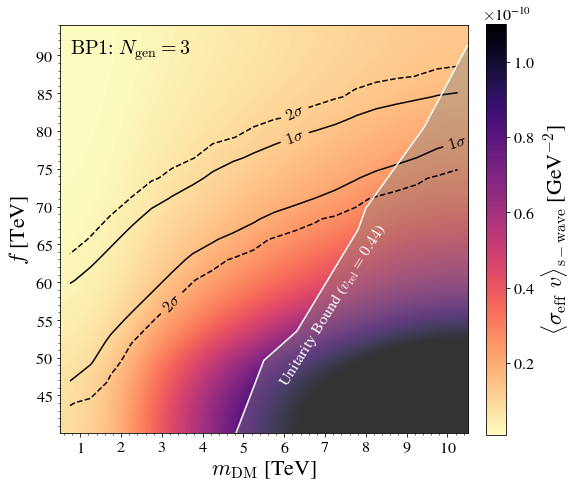

In [27]:
#-- Set stylistic elements of plot --#
aeffPlotArgs = {  'plotTitle':  '',
                  'zAxisTitle': r'$\langle \sigma_{\rm eff} ~v \rangle_{\rm s-wave}$ [GeV$^{-2}$]',
                  'xAxisTitle': xAxisTitle,
                  'yAxisTitle': yAxisTitle,
                  'interpType': 'quadric',
                  'cmap':       plt.cm.get_cmap('magma').reversed(),
                  'cmap_range': (1e-12, 1.1e-10),
                  'axisRange':  axisRange,
                  'plotName':   plotName}

aeffPlotArgs['axisTicks'] = {}
aeffPlotArgs['axisTicks']['xticks'] = [1,2,3,4,5,6,7,8,9,10]
aeffPlotArgs['axisTicks']['yticks'] = [45, 50, 55, 60, 65, 70, 75, 80, 85, 90]
aeffPlotArgs['axisTicks']['minorticks'] = True

#-- Set contour elements of plot --#
aeffContourDict = {}

# Set profile likelihood significance plot
aeffContourDict['1sigContour'] = {}
aeffContourDict['1sigContour']['X_surface']    = likelihoodDict["X"]
aeffContourDict['1sigContour']['Y_surface']    = likelihoodDict["Y"]
aeffContourDict['1sigContour']['Z_surface']    = likelihoodDict["Z"]
aeffContourDict['1sigContour']['Z_constraint'] = np.full(likelihoodDict["Z"].shape, likelihoodDict["critDensity"][1])
aeffContourDict['1sigContour']['color']        = 'black'
aeffContourDict['1sigContour']['linestyle']    = '-'
aeffContourDict['1sigContour']['label']        = r'$1 \sigma$' 
aeffContourDict['1sigContour']['fontsize']     = 16

# Set profile likelihood significance plot
aeffContourDict['2sigContour'] = {}
aeffContourDict['2sigContour']['X_surface']    = likelihoodDict["X"]
aeffContourDict['2sigContour']['Y_surface']    = likelihoodDict["Y"]
aeffContourDict['2sigContour']['Z_surface']    = likelihoodDict["Z"]
aeffContourDict['2sigContour']['Z_constraint'] = np.full(likelihoodDict["Z"].shape, likelihoodDict["critDensity"][0])
aeffContourDict['2sigContour']['color']        = 'black'
aeffContourDict['2sigContour']['linestyle']    = '--'
aeffContourDict['2sigContour']['label']        = r'$2 \sigma$' 
aeffContourDict['2sigContour']['fontsize']     = 16

# Set unitarity limit plot
aeffContourDict['unitarityContour'] = {}
aeffContourDict['unitarityContour']['X_surface']    = m1AeffDict["X"]
aeffContourDict['unitarityContour']['Y_surface']    = m1AeffDict["Y"]
aeffContourDict['unitarityContour']['Z_surface']    = m1AeffDict["aeff"].T
aeffContourDict['unitarityContour']['Z_constraint'] = Z_unitarityConstraint
aeffContourDict['unitarityContour']['color']        = 'white'
aeffContourDict['unitarityContour']['linestyle']    = '-'
aeffContourDict['unitarityContour']['label']        = r'Unitarity Bound ($v_{\rm rel} = %s$)'%str(v_rel)
aeffContourDict['unitarityContour']['fontsize']     = 16
aeffContourDict['unitarityContour']['inline']       = False
aeffContourDict['unitarityContour']['delta_x']      = -0.08  #-0.27 # x position change in fraction of x
aeffContourDict['unitarityContour']['delta_y']      = -0.15 #-0.2  # y position change in fraction of y
aeffContourDict['unitarityContour']['delta_rot']    = -2    #-2    # rotation change in degrees
aeffContourDict['unitarityContour']['shade']        = {}
aeffContourDict['unitarityContour']['shade']['yLimit'] = m1AeffDict["Y"].min()
aeffContourDict['unitarityContour']['shade']['color']  = 'grey'#'white'
aeffContourDict['unitarityContour']['shade']['alpha']  = 0.4

#-- Set misc. text elements of plot --#
aeffTextDict = {}

# Set figure labels as plot text
aeffTextDict['BP_Ngen'] = {}
aeffTextDict['BP_Ngen']['x']        = 1.5*m1AeffDict["X"].min()
aeffTextDict['BP_Ngen']['y']        = 0.96*m1AeffDict["Y"].max()
aeffTextDict['BP_Ngen']['text']     = r"${\rm BP} %s$: $N_{\rm gen} = %s$"%(str(BP), str(NGEN))
aeffTextDict['BP_Ngen']['fontsize'] = 20

plotZcmap(aeffPlotArgs, m1AeffDict["X"], m1AeffDict["Y"], m1AeffDict["aeff"], contourDict=aeffContourDict, textDict=aeffTextDict)

In [28]:
def convertAeffUnits(aeff):
    # aeff units     = GeV^-2
    # new aeff units = cm^3/s
    # Note assuming natural units: c = h = 1
    

    # GeV^{-2} c^3 h^2 = 4.6084 * 10-16 cm^3/s
    unitConvFactor = 4.6084*(10**-16)
    
    return unitConvFactor*aeff

m1AeffDict["aeff_cm3sinv"] = convertAeffUnits(m1AeffDict["aeff"])

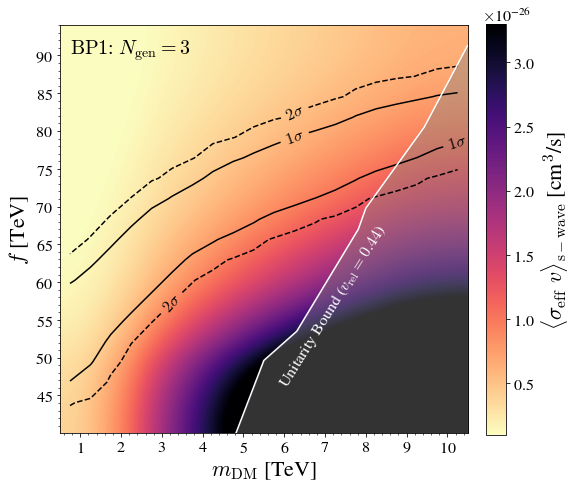

In [29]:
#-- Convert units of a_eff and remake plot --#
aeffPlotArgs['zAxisTitle'] = r'$\langle \sigma_{\rm eff} ~v \rangle_{\rm s-wave}$ [cm$^{3}$/s]' 
aeffPlotArgs['plotName']   = 'paperPlots/%s_Ngen%s_aeff_convUnits.pdf'%(PLOTRANGE, str(NGEN))
aeffPlotArgs['cmap_range'] = (1e-27, 3.3e-26)

plotZcmap(aeffPlotArgs, m1AeffDict["X"], m1AeffDict["Y"], m1AeffDict["aeff_cm3sinv"], contourDict=aeffContourDict, textDict=aeffTextDict)

# Make scaling plot

We want to find the scaling properties of $\langle \sigma_{\rm eff} ~v_{\rm rel} \rangle$. We guess that it scales as
$\langle \sigma_{\rm eff} ~v_{\rm rel} \rangle \approx c \frac{m_{\rm DM}}{f^3}$.

Therefore, we want to plot $\langle \sigma_{\rm eff} ~v_{\rm rel} \rangle \frac{f^3}{m_{\rm DM}} \approx c$. We then choose the value of c in the middle of the plot and plot $c^{-1} \langle \sigma_{\rm eff} ~v_{\rm rel} \rangle \frac{f^3}{m_{\rm DM}}$.

In [30]:
# Y and X are in TeV but aeff is in GeV. 1 TeV = 1000 GeV
if CASE == 4: #! Do more generally later
    X, Y = 1000*m1AeffDict["X"], 1000*m1AeffDict["Y"]
else:
    X, Y = m1AeffDict["X"], m1AeffDict["Y"]

m1AeffDict["aeff_scaled"] = m1AeffDict["aeff"]*((Y)**3)/(X)

# Calculate middle value
mid = int(m1AeffDict["aeff_scaled"].shape[0]/2)
c   = m1AeffDict["aeff_scaled"][mid,mid]
print(m1AeffDict["aeff_scaled"].min(), m1AeffDict["aeff_scaled"].max(), c)

# Normalize to this middle value
m1AeffDict["aeff_scaled"] = m1AeffDict["aeff_scaled"]*(1./c)
print(m1AeffDict["aeff_scaled"].min(), m1AeffDict["aeff_scaled"].max())

# Set c-value string
from plotUtils import sciNotationString
cValStr = sciNotationString(c)[1:-1]
print(cValStr)

if cValStr[-3:-1] == '00':
    cValStr = cValStr[0:4]

1.0668124035976323 1.0904499971700954 1.067862635859671
0.9990165099641367 1.0211519352320448
1.07 \times 10^{+00}


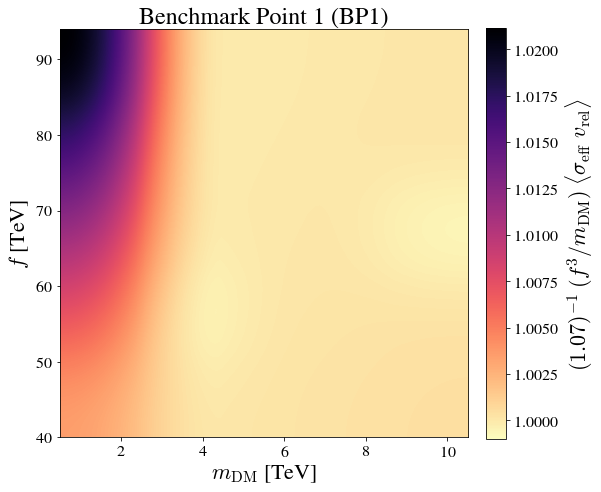

In [31]:
#-- Set stylistic elements of plot --#
scalePlotArgs = {  'plotTitle':  plotTitle,
                  'zAxisTitle': r'$(%s)^{-1}$ $(f^3/ m_{\rm DM})$ $\langle \sigma_{\rm eff} ~v_{\rm rel} \rangle$ '%cValStr,
                  'xAxisTitle': xAxisTitle,
                  'yAxisTitle': yAxisTitle,
                  'interpType': 'quadric',
                  'cmap':       plt.cm.get_cmap('magma').reversed(),
                  'axisRange':  axisRange,
                  'plotName':   'paperPlots/%s_Ngen%s_ratio.pdf'%(PLOTRANGE, str(NGEN))}

plotZcmap(scalePlotArgs, m1AeffDict["X"], m1AeffDict["Y"], m1AeffDict["aeff_scaled"])